# Deep Learning with PyTorch : Build a Generative Adversarial Network 

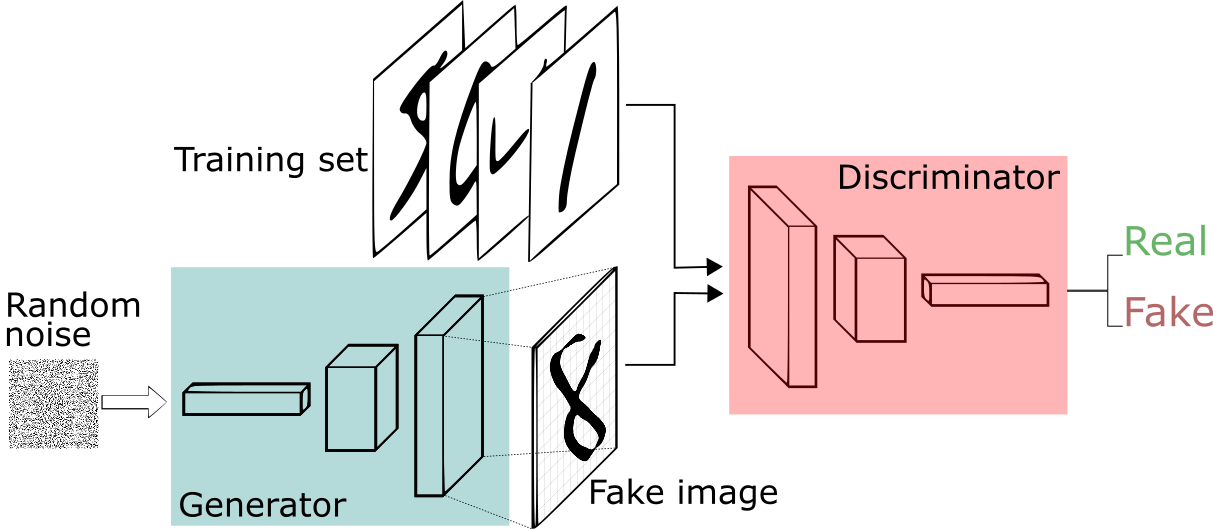

In [31]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [32]:
device = 'cuda'

batch_size =128

noise_vector_dim= 64

#optimizer parameters
learning_rate= 0.0002
beta1=0.5
beta2=0.99
epochs=20


# Load MNIST Dataset 

In [33]:
from torchvision import datasets
import torchvision.transforms as transforms

In [34]:
train_augs= transforms.Compose([
    transforms.RandomRotation((-20,+20)),
    transforms.ToTensor()
])

In [35]:
trainset = datasets.MNIST('MNIST/',download=True, train=True,transform=train_augs)

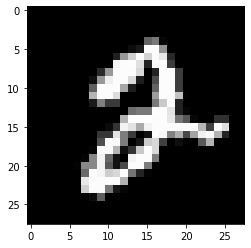

In [36]:
image, label =trainset[5]
plt.imshow(image.squeeze() ,cmap='gray')

In [37]:
print("Total images in trainset:" ,len(trainset))

Total images in trainset: 60000


# Load Dataset Into Batches 

In [38]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [39]:
trainloader = DataLoader(trainset,batch_size= batch_size, shuffle= True)

In [40]:
print ("Total number of batches:", len(trainloader))

Total number of batches: 469


In [41]:
dataiter = iter(trainloader)
images,_ = next(dataiter)
print(images.shape)


torch.Size([128, 1, 28, 28])


In [42]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

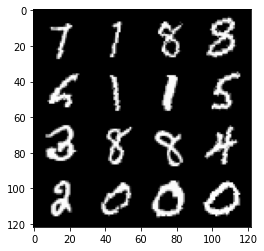

In [43]:

show_tensor_images(images, num_images=16)

# Create Discriminator Network 

In [44]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from torch import nn
from torchsummary import summary

In [46]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [47]:
from torch.nn.modules.activation import LeakyReLU
def get_disc_block(in_channels, out_channels ,kernel_size ,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )


In [48]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.block1= get_disc_block(1,16,(3,3),2)
    self.block2= get_disc_block(16,32,(5,5),2)
    self.block3= get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.Linear = nn.Linear(in_features=64, out_features=1)

  def forward(self,images):
    x= self.block1(images)
    x= self.block2(x)
    x= self.block3(x)
    x= self.flatten(x)
    x =self.Linear(x)
    return x

In [49]:
D = Discriminator()
D.to(device)
summary(D, input_size=(1,28,28))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [50]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [51]:
def get_gen_block(in_channels, out_channels ,kernel_size ,stride, final_block= False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels ,kernel_size ,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels ,kernel_size ,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [52]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()
    self.noise_dim= noise_dim
    self.block1= get_gen_block(noise_dim,256,(3,3),2)
    self.block2= get_gen_block(256,128,(4,4),1)
    self.block3= get_gen_block(128,64,(3,3),2)
    self.block4= get_gen_block(64,1,(4,4),2, final_block= True)

  def forward(self,r_noise_vec):
    x= r_noise_vec.view(-1, self.noise_dim,1,1)
    x= self.block1(x)
    x= self.block2(x)
    x= self.block3(x)
    x= self.block4(x)
   
    return x
    
    

In [53]:
G= Generator(noise_vector_dim)
G.to(device)
summary(G, input_size=(1,noise_vector_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [54]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [55]:
D= D.apply(weights_init)
G= G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [62]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [63]:
D_opt= torch.optim.Adam(D.parameters(),lr= learning_rate, betas=(beta1,beta2))
G_opt= torch.optim.Adam(G.parameters(),lr= learning_rate, betas=(beta1,beta2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.45510956015922366 | G_loss: 1.0616183230109306


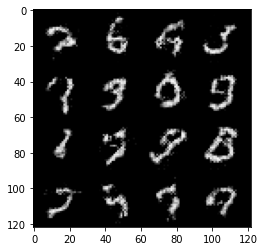

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.42555988641944265 | G_loss: 1.1514658453876276


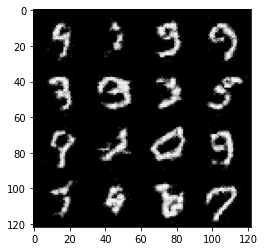

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.4160178821605406 | G_loss: 1.20881489827943


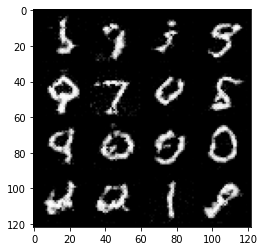

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.4048478235440976 | G_loss: 1.271052580398283


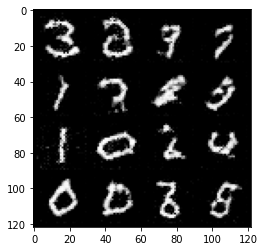

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.39764091950743946 | G_loss: 1.323396719722097


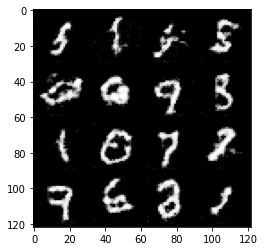

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.38292116346135574 | G_loss: 1.3867140106046631


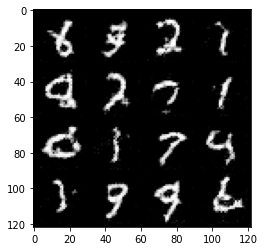

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.3743898766254311 | G_loss: 1.4456810855916313


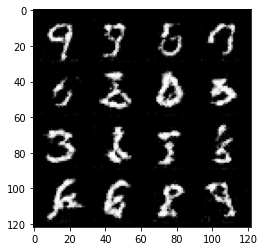

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.37835756141239646 | G_loss: 1.46285799152053


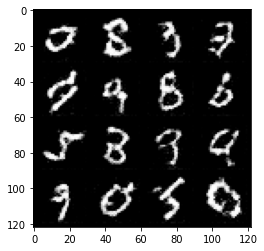

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.38283990663506073 | G_loss: 1.489305180527254


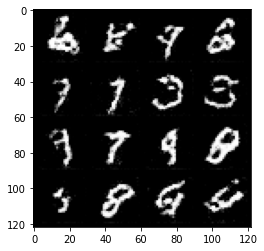

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.39301053884186976 | G_loss: 1.4688433661643885


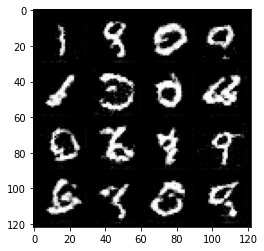

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.39586259052951706 | G_loss: 1.4935568090695053


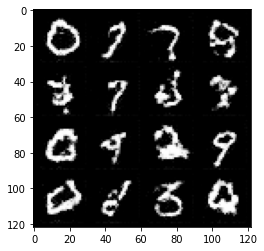

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.4037603881440437 | G_loss: 1.4752542856913895


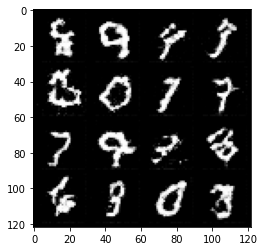

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.4002566634973229 | G_loss: 1.499519680862996


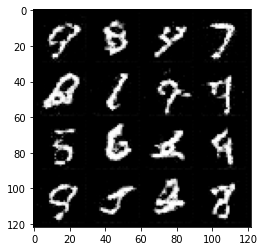

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.40604576659100905 | G_loss: 1.4998617107425924


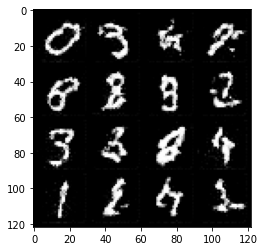

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.4098252938119079 | G_loss: 1.506634388396989


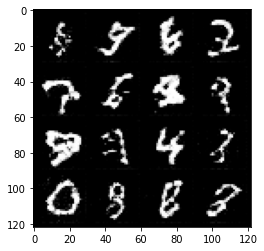

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.4140378867766496 | G_loss: 1.51120015311597


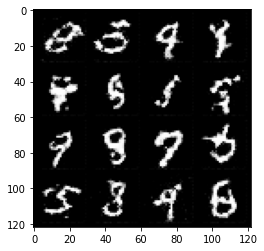

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.40808787973704874 | G_loss: 1.529716248069999


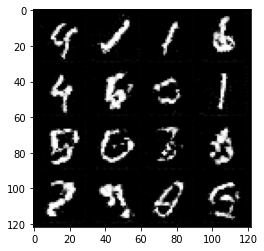

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.4211014085995363 | G_loss: 1.5144309149876332


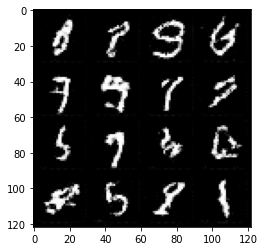

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.4125996911957828 | G_loss: 1.53651548677416


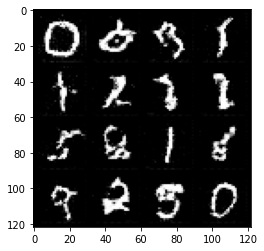

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.427056518000072 | G_loss: 1.5135309954823206


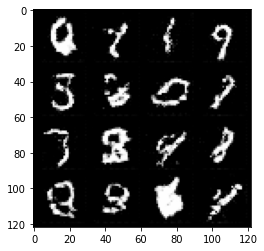

In [67]:
for i in range(epochs):
  total_d_loss= 0.0
  total_g_loss= 0.0
  
  for real_img,_ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_vector_dim, device=device)

    D_opt.zero_grad()

    fake_img = G(noise) 
    D_pred= D(fake_img)
    D_fake_loss= fake_loss(D_pred)
    D_pred= D(real_img)
    D_real_loss= real_loss(D_pred)

    D_loss= (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()
    

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_vector_dim, device=device)
    fake_img= G(noise)

    D_pred= D(fake_img)
    G_loss= real_loss(D_pred)
    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

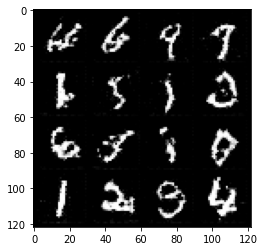

In [68]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_vector_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya